
-- Dataset head --
     location.name              location.region location.terrain  \
0         An Giang      Đồng Bằng Sông Cửu Long        đồng bằng   
1  Bà Rịa-Vũng Tàu                  Đông Nam Bộ         ven biển   
2        Bắc Giang  Trung du và miền núi Bắc Bộ         miền núi   
3          Bắc Kạn  Trung du và miền núi Bắc Bộ         miền núi   
4         Bạc Liêu      Đồng Bằng Sông Cửu Long         ven biển   

  location.country  location.lat  location.lon        date  date_epoch  \
0          Vietnam       10.7000      105.1167  2024-04-21  1713657600   
1          Vietnam       10.3500      107.0667  2024-04-21  1713657600   
2          Vietnam       21.2667      106.2000  2024-04-21  1713657600   
3          Vietnam       22.1333      105.8333  2024-04-21  1713657600   
4          Vietnam        9.2850      105.7244  2024-04-21  1713657600   

   day.maxtemp_c  day.maxtemp_f  ...             day.condition.text  \
0           38.6          101.5  ...                   

C:\Users\nvqua\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step
Metrics for Hanoi:
{'RNN': {'MAE': 2.763675773042741, 'MSE': 11.067122548565491, 'RMSE': 3.3267285053886635, 'R2': 0.2613954413826174}, 'LSTM': {'MAE': 2.9436737280780974, 'MSE': 12.348238691533457, 'RMSE': 3.5140060744872734, 'R2': 0.17589550956546152}}


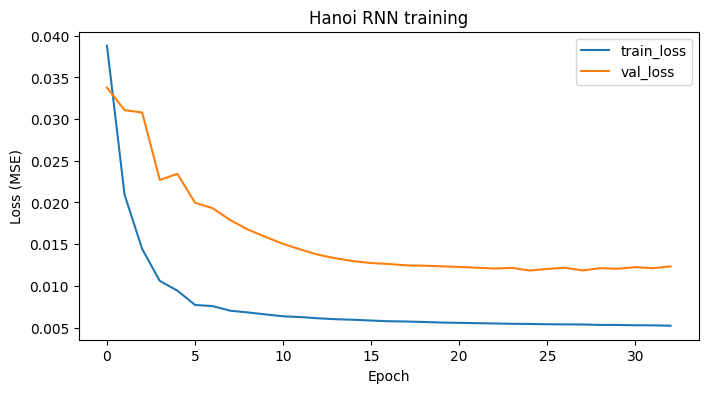

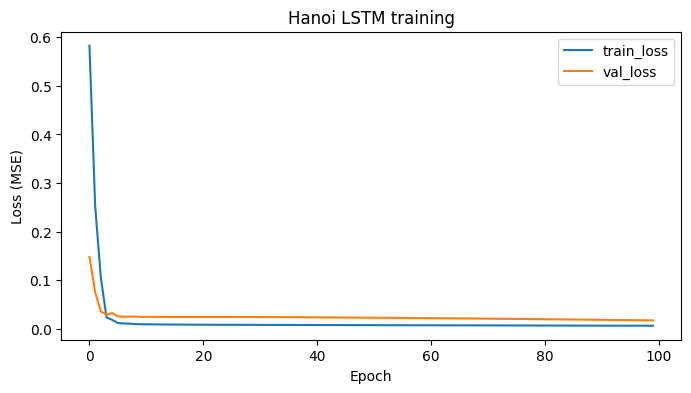

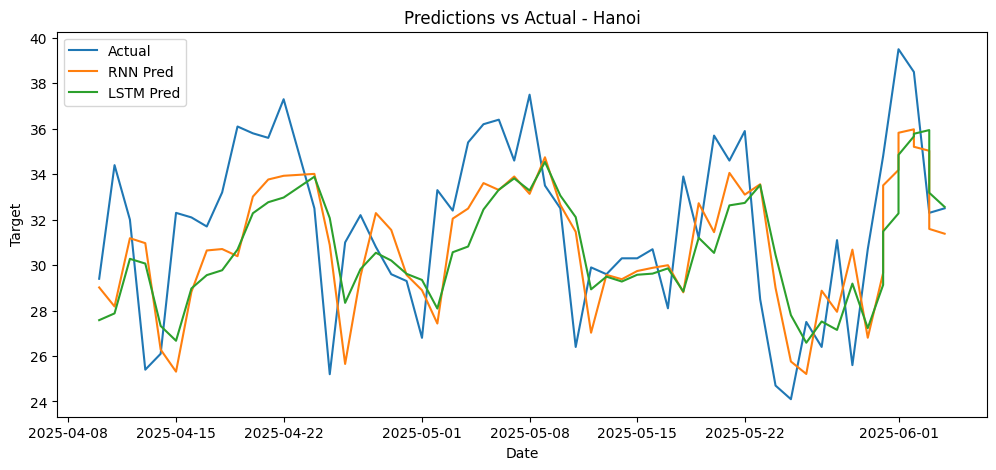

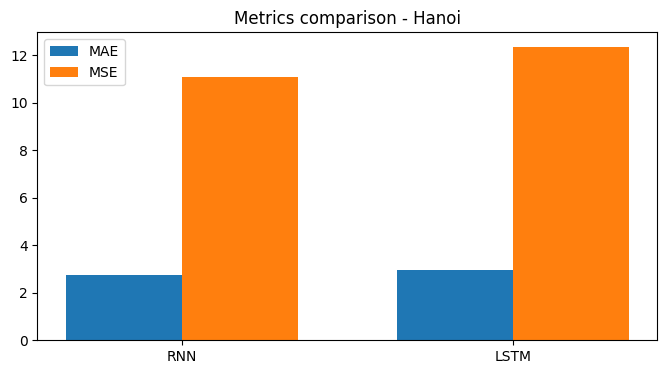

Danang features: ['day.maxtemp_c', 'day.maxtemp_f', 'day.mintemp_c', 'day.mintemp_f']


C:\Users\nvqua\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001725AD73D80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step
Metrics for Danang:
{'RNN': {'MAE': 1.3151945041397868, 'MSE': 3.767677155054501, 'RMSE': 1.9410505287226556, 'R2': 0.3061408418001157}, 'LSTM': {'MAE': 1.945

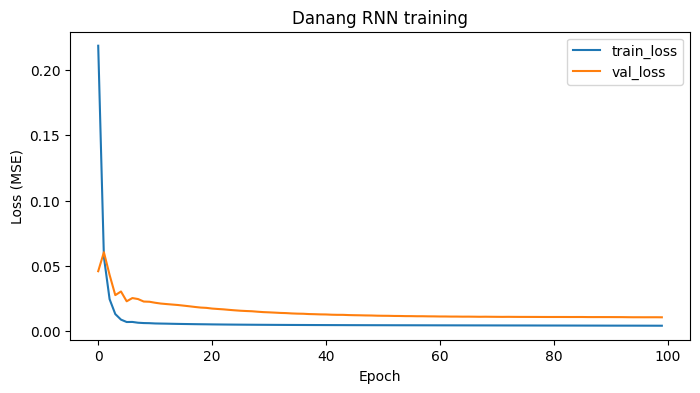

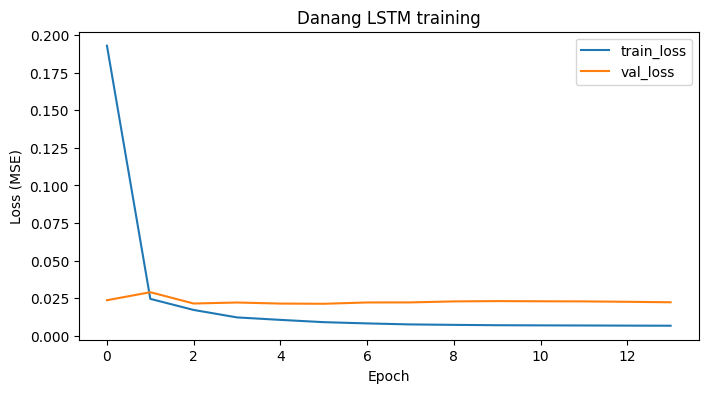

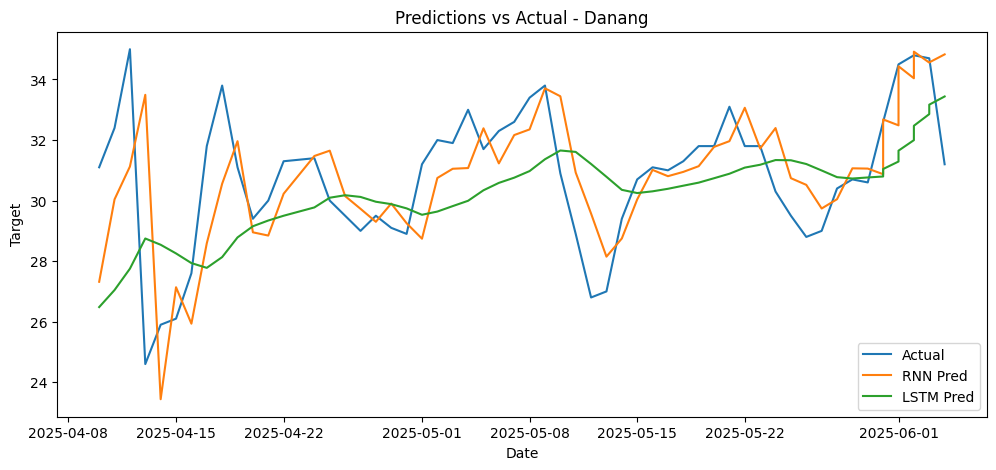

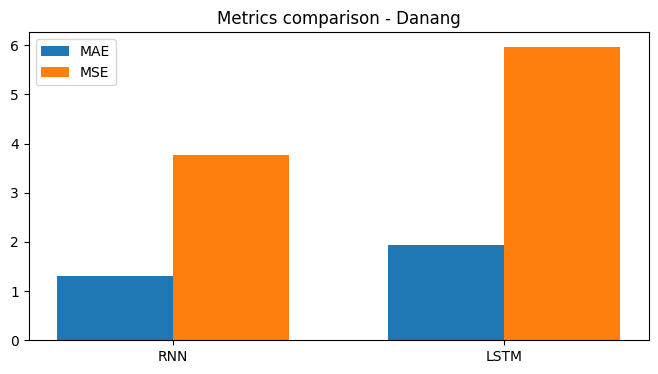


=== Summary comparison across cities ===
     city   rnn_MAE    rnn_MSE  rnn_RMSE    rnn_R2  lstm_MAE   lstm_MSE  \
0   Hanoi  2.763676  11.067123  3.326729  0.261395  2.943674  12.348239   
1  Danang  1.315195   3.767677  1.941051  0.306141  1.945801   5.963110   

   lstm_RMSE   lstm_R2  
0   3.514006  0.175896  
1   2.441948 -0.098172  
Saved models for Hanoi -> model_Hanoi_rnn.h5, model_Hanoi_lstm.h5
Saved models for Danang -> model_Danang_rnn.h5, model_Danang_lstm.h5


In [4]:
# Weather forecasting with RNN and LSTM
# Dataset: user-provided file "weather_2.csv" (from Kaggle link)
# This script follows the 3 phases of deep learning model development (Chapter 5 style):
# 1) Data preparation & exploration
# 2) Modeling (build/train/tune)
# 3) Evaluation & deployment-ready artifacts

# Instructions: Place 'weather_2.csv' in the same folder as this script or update the PATH variable below.
# Run with Python 3.9+; recommended to run inside a virtualenv with packages: numpy,pandas,scikit-learn,matplotlib,tensorflow

"""
Phases (short description to include in any report):

Phase 1 - Data & Problem Framing
  - Understand the problem (forecast daily weather for 3 cities: Ha Noi, Da Nang, HCMC)
  - Inspect dataset (columns, missing data, date ranges)
  - Choose target(s) (e.g., daily average temperature) and input features
  - Split data into train/validation/test (time-based split)

Phase 2 - Modeling
  - Choose candidate models (RNN, LSTM)
  - Prepare time-series windows and normalization
  - Train models, track metrics and losses
  - Tune hyperparameters (sequence length, units, learning rate)

Phase 3 - Evaluation & Delivery
  - Evaluate on hold-out test set using MAE, MSE, RMSE, R2
  - Visualize predictions vs actuals
  - Compare models across cities and metrics
  - Save models and produce a simple inference function for deployment
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# ---------------------------
# User settings
# ---------------------------
DATA_PATH = 'weather2.csv'  # change if needed
CITIES = ['Hanoi', 'Ha Noi', 'Hà Nội', 'HaNoi', 'HANOI']
DANANG_VARIANTS = ['Da Nang', 'Đà Nẵng', 'Danang', 'DA NANG']
HCM_VARIANTS = ['Ho Chi Minh', 'Hồ Chí Minh', 'HCM', 'TP HCM', 'TPHCM', 'TP. Hồ Chí Minh']
TARGET_COLUMN = 'Temperature'  # default target; the script will try to find a matching column
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---------------------------
# Utility functions
# ---------------------------

def load_and_inspect(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}. Please put your CSV there or update DATA_PATH.")
    df = pd.read_csv(path)
    print('\n-- Dataset head --')
    print(df.head())
    print('\n-- Columns --')
    print(df.columns.tolist())
    print('\n-- Dtypes and missing values --')
    print(df.info())
    print('\n-- Missing values count --')
    print(df.isna().sum())
    return df


def normalize_city_name(s):
    if pd.isna(s):
        return s
    s = str(s).strip()
    lowered = s.lower()
    if any(v.lower() == lowered for v in CITIES):
        return 'Hanoi'
    if any(v.lower() == lowered for v in DANANG_VARIANTS):
        return 'Danang'
    if any(v.lower() == lowered for v in HCM_VARIANTS):
        return 'HCMC'
    return s


def prepare_city_df(df, city_label='Hanoi'):
    df = df.copy()
    # try common column names for date and city
    date_cols = [c for c in df.columns if 'date' in c.lower()]
    city_cols = [c for c in df.columns if 'city' in c.lower() or 'location' in c.lower()]

    if not date_cols:
        raise ValueError('No date-like column found in dataset. Please include a Date column.')
    date_col = date_cols[0]

    if not city_cols:
        # perhaps the city is stored in 'Location' or similar
        raise ValueError('No city/location column found. Please ensure dataset contains a city/location column.')
    city_col = city_cols[0]

    df[date_col] = pd.to_datetime(df[date_col])
    df['city_norm'] = df[city_col].apply(normalize_city_name)
    city_df = df[df['city_norm'] == city_label].sort_values(date_col)
    city_df = city_df.reset_index(drop=True)
    return city_df, date_col


def find_numeric_feature_candidates(df):
    # return numeric columns except potential id/index/date/city
    exclude = [c for c in df.columns if 'date' in c.lower() or 'city' in c.lower() or 'location' in c.lower()]
    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    candidates = [c for c in nums if c not in exclude]
    return candidates


def create_sequences(values, seq_len):
    # values: numpy array shape (n_samples, n_features)
    X, y = [], []
    for i in range(len(values) - seq_len):
        X.append(values[i:i+seq_len])
        y.append(values[i+seq_len, 0])  # target is first column in values
    return np.array(X), np.array(y)


def build_rnn_model(input_shape, units=32, lr=0.001):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=input_shape))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model


def build_lstm_model(input_shape, units=50, lr=0.001):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model

# ---------------------------
# Main pipeline function per city
# ---------------------------

def run_pipeline_for_city(df_city, date_col, features, target_col, seq_len=14, test_ratio=0.15, val_ratio=0.15,
                         rnn_params=None, lstm_params=None, epochs=100, batch_size=32):
    """
    df_city: DataFrame for single city sorted by date
    features: list of column names (first in list must be the target column)
    target_col: name of target column (should be features[0])
    """
    if rnn_params is None:
        rnn_params = {}
    if lstm_params is None:
        lstm_params = {}

    data = df_city[features].copy()
    data = data.dropna()
    dates = df_city[date_col].iloc[len(df_city) - len(data):].reset_index(drop=True)

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data.values)

    X, y = create_sequences(scaled, seq_len)
    n_samples = len(X)
    test_size = int(n_samples * test_ratio)
    val_size = int(n_samples * val_ratio)
    train_end = n_samples - test_size - val_size

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:train_end+val_size], y[train_end:train_end+val_size]
    X_test, y_test = X[train_end+val_size:], y[train_end+val_size:]

    # Build and train RNN
    input_shape = (X_train.shape[1], X_train.shape[2])
    rnn_model = build_rnn_model(input_shape, **rnn_params)
    es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    history_rnn = rnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs,
                                batch_size=batch_size, callbacks=[es], verbose=0)

    # Build and train LSTM
    lstm_model = build_lstm_model(input_shape, **lstm_params)
    es2 = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    history_lstm = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs,
                                  batch_size=batch_size, callbacks=[es2], verbose=0)

    # Predictions (remember outputs are scaled for target index 0)
    def inv_transform_target(scaled_y):
        # scaled_y: shape (n,) predicted values corresponding to first feature (target)
        # To invert, we need to create placeholder for other features (use zeros mean)
        dummy = np.zeros((len(scaled_y), scaled.shape[1]))
        dummy[:,0] = scaled_y
        inv = scaler.inverse_transform(dummy)[:,0]
        return inv

    pred_rnn_scaled = rnn_model.predict(X_test).flatten()
    pred_lstm_scaled = lstm_model.predict(X_test).flatten()
    y_test_inv = inv_transform_target(y_test)
    pred_rnn_inv = inv_transform_target(pred_rnn_scaled)
    pred_lstm_inv = inv_transform_target(pred_lstm_scaled)

    # Metrics
    metrics = {}
    for name, y_pred in [('RNN', pred_rnn_inv), ('LSTM', pred_lstm_inv)]:
        mae = mean_absolute_error(y_test_inv, y_pred)
        mse = mean_squared_error(y_test_inv, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_inv, y_pred)
        metrics[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

    results = {
        'scaler': scaler,
        'rnn_model': rnn_model,
        'lstm_model': lstm_model,
        'history_rnn': history_rnn.history,
        'history_lstm': history_lstm.history,
        'X_test_dates': dates.iloc[seq_len + train_end + val_size:].reset_index(drop=True) if len(dates) > 0 else None,
        'y_test': y_test_inv,
        'pred_rnn': pred_rnn_inv,
        'pred_lstm': pred_lstm_inv,
        'metrics': metrics
    }
    return results

# ---------------------------
# Plotting utilities
# ---------------------------

def plot_training_history(history, title='Training loss'):
    plt.figure(figsize=(8,4))
    plt.plot(history['loss'], label='train_loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()


def plot_predictions(dates, actual, pred1, pred2, city_name='City'):
    plt.figure(figsize=(12,5))
    plt.plot(dates, actual, label='Actual')
    plt.plot(dates, pred1, label='RNN Pred')
    plt.plot(dates, pred2, label='LSTM Pred')
    plt.title(f'Predictions vs Actual - {city_name}')
    plt.xlabel('Date')
    plt.ylabel('Target')
    plt.legend()
    plt.show()


def plot_comparison_bar(metrics_dict, city_name='City'):
    # metrics_dict: {'RNN': {'MAE':..,'MSE':..}, 'LSTM': {...}}
    names = list(metrics_dict.keys())
    maes = [metrics_dict[n]['MAE'] for n in names]
    mses = [metrics_dict[n]['MSE'] for n in names]

    x = np.arange(len(names))
    width = 0.35

    plt.figure(figsize=(8,4))
    plt.bar(x - width/2, maes, width, label='MAE')
    plt.bar(x + width/2, mses, width, label='MSE')
    plt.xticks(x, names)
    plt.title(f'Metrics comparison - {city_name}')
    plt.legend()
    plt.show()

# ---------------------------
# Run for each city (main)
# ---------------------------

def main(path=DATA_PATH):
    df = load_and_inspect(path)

    # Try to find target column intelligently
    possible_temp_cols = [c for c in df.columns if 'temp' in c.lower()]
    global TARGET_COLUMN
    if possible_temp_cols:
        TARGET_COLUMN = possible_temp_cols[0]
        print(f"Using target column: {TARGET_COLUMN}")
    else:
        print('No obvious temperature column found. Using default TARGET_COLUMN value; you may need to adjust it.')

    # We'll attempt to extract city-specific dataframes for three target cities
    cities = {'Hanoi': None, 'Danang': None, 'HCMC': None}
    for city_label in cities.keys():
        try:
            df_city, date_col = prepare_city_df(df, city_label)
            if df_city.empty:
                print(f'No rows for {city_label}')
            else:
                cities[city_label] = (df_city, date_col)
                print(f'Prepared {len(df_city)} rows for {city_label}')
        except Exception as e:
            print(f'Could not prepare dataframe for {city_label}: {e}')

    # For each city, choose features automatically: pick target + up to 3 numeric features
    overall_results = {}
    for city_name, item in cities.items():
        if item is None:
            continue
        df_city, date_col = item
        candidates = find_numeric_feature_candidates(df_city)
        if TARGET_COLUMN not in candidates:
            # Maybe the target isn't numeric or has different name; try to pick first numeric
            if candidates:
                target = candidates[0]
            else:
                print(f'No numeric candidates for {city_name}, skipping...')
                continue
        else:
            target = TARGET_COLUMN
        # assemble features: target first, then up to 3 more features
        other_feats = [c for c in candidates if c != target][:3]
        features = [target] + other_feats
        print(f'{city_name} features: {features}')

        results = run_pipeline_for_city(df_city, date_col, features, target_col=target,
                                        seq_len=14, epochs=100, batch_size=32)

        overall_results[city_name] = {'features': features, 'results': results}

        # plots
        print(f"Metrics for {city_name}:")
        print(results['metrics'])
        plot_training_history(results['history_rnn'], title=f'{city_name} RNN training')
        plot_training_history(results['history_lstm'], title=f'{city_name} LSTM training')
        # plot predictions if dates available
        if results['X_test_dates'] is not None and len(results['y_test'])>0:
            plot_predictions(results['X_test_dates'], results['y_test'], results['pred_rnn'], results['pred_lstm'], city_name)
            plot_comparison_bar(results['metrics'], city_name)

    # Summary table
    rows = []
    for city, v in overall_results.items():
        metrics = v['results']['metrics']
        row = {
            'city': city,
            'rnn_MAE': metrics['RNN']['MAE'],
            'rnn_MSE': metrics['RNN']['MSE'],
            'rnn_RMSE': metrics['RNN']['RMSE'],
            'rnn_R2': metrics['RNN']['R2'],
            'lstm_MAE': metrics['LSTM']['MAE'],
            'lstm_MSE': metrics['LSTM']['MSE'],
            'lstm_RMSE': metrics['LSTM']['RMSE'],
            'lstm_R2': metrics['LSTM']['R2']
        }
        rows.append(row)
    if rows:
        summary_df = pd.DataFrame(rows)
        print('\n=== Summary comparison across cities ===')
        print(summary_df)

    # Optionally save models
    SAVE_MODELS = True
    if SAVE_MODELS:
        for city, v in overall_results.items():
            res = v['results']
            rnn_path = f'model_{city}_rnn.h5'
            lstm_path = f'model_{city}_lstm.h5'
            res['rnn_model'].save(rnn_path)
            res['lstm_model'].save(lstm_path)
            print(f'Saved models for {city} -> {rnn_path}, {lstm_path}')

    return overall_results


if __name__ == '__main__':
    main()



-- Dataset head --
     location.name              location.region location.terrain  \
0         An Giang      Đồng Bằng Sông Cửu Long        đồng bằng   
1  Bà Rịa-Vũng Tàu                  Đông Nam Bộ         ven biển   
2        Bắc Giang  Trung du và miền núi Bắc Bộ         miền núi   
3          Bắc Kạn  Trung du và miền núi Bắc Bộ         miền núi   
4         Bạc Liêu      Đồng Bằng Sông Cửu Long         ven biển   

  location.country  location.lat  location.lon        date  date_epoch  \
0          Vietnam       10.7000      105.1167  2024-04-21  1713657600   
1          Vietnam       10.3500      107.0667  2024-04-21  1713657600   
2          Vietnam       21.2667      106.2000  2024-04-21  1713657600   
3          Vietnam       22.1333      105.8333  2024-04-21  1713657600   
4          Vietnam        9.2850      105.7244  2024-04-21  1713657600   

   day.maxtemp_c  day.maxtemp_f  ...             day.condition.text  \
0           38.6          101.5  ...                   

C:\Users\nvqua\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step
Metrics for Hanoi:
{'RNN': {'MAE': 2.5767081408177375, 'MSE': 10.189694359643175, 'RMSE': 3.1921300662164716, 'R2': 0.31995379359689}, 'LSTM': {'MAE': 2.752220922809534, 'MSE': 11.182636709900004, 'RMSE': 3.344044962302392, 'R2': 0.2536861849094798}}


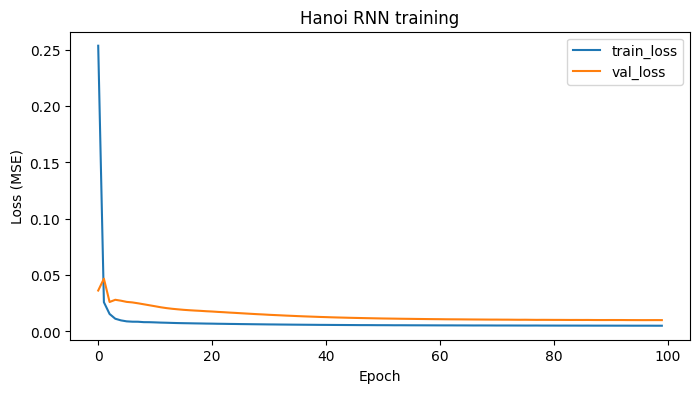

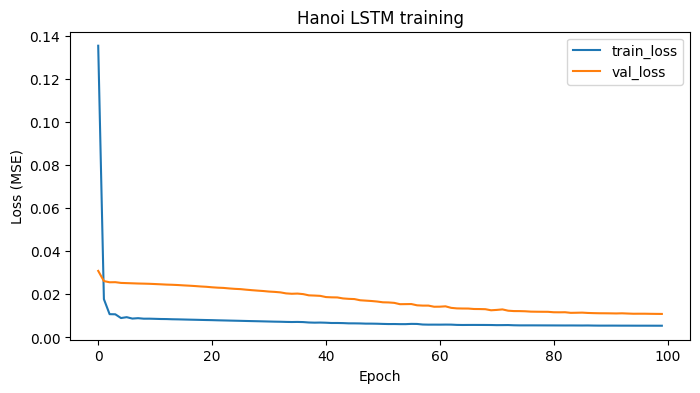

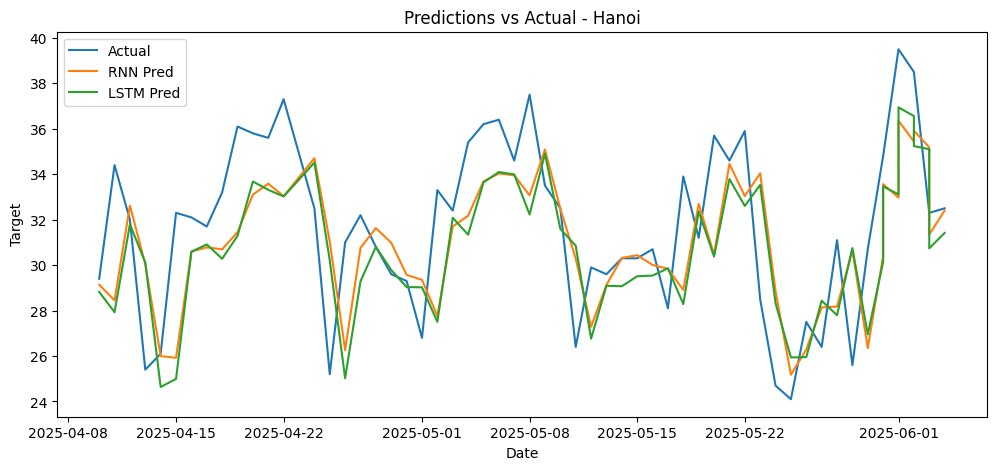

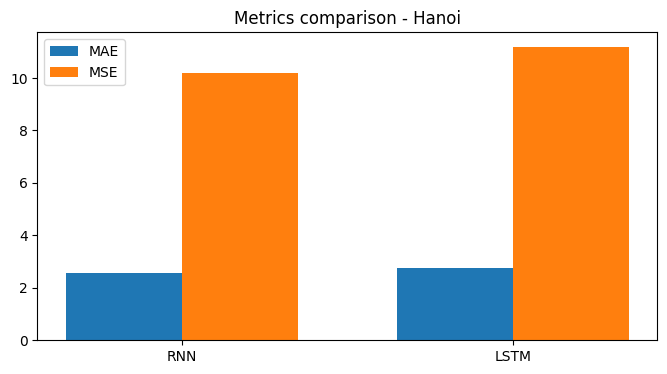

Danang features: ['day.maxtemp_c', 'day.maxtemp_f', 'day.mintemp_c', 'day.mintemp_f']


C:\Users\nvqua\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 474ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step
Metrics for Danang:
{'RNN': {'MAE': 1.367069606053627, 'MSE': 3.820015213995866, 'RMSE': 1.954485920644062, 'R2': 0.29650221300461155}, 'LSTM': {'MAE': 1.8922020217119635, 'MSE': 5.700256906339712, 'RMSE': 2.387521079768661, 'R2': -0.04976496015586451}}


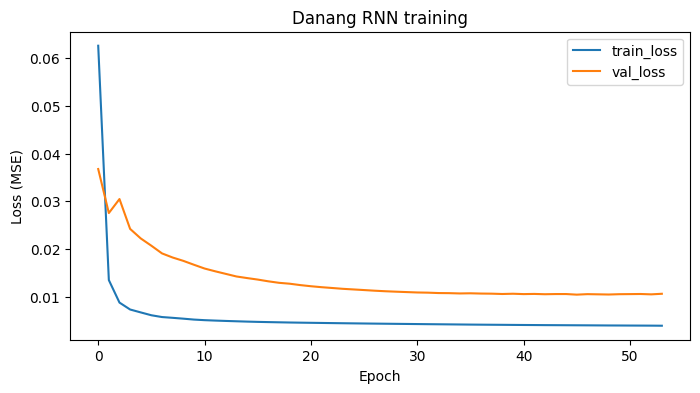

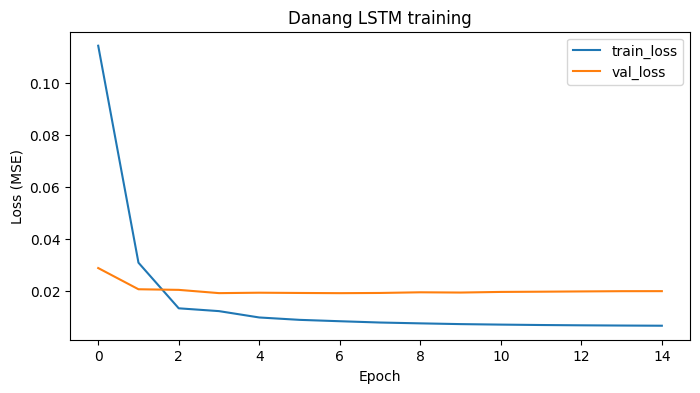

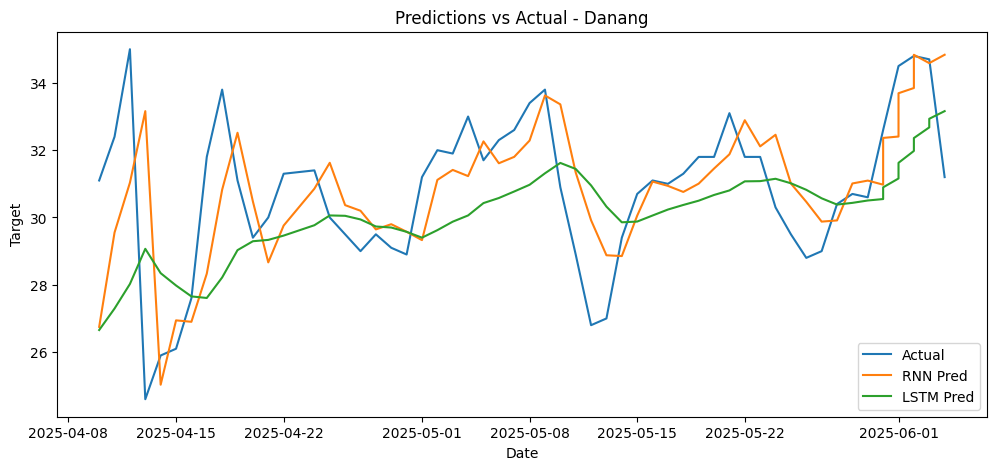

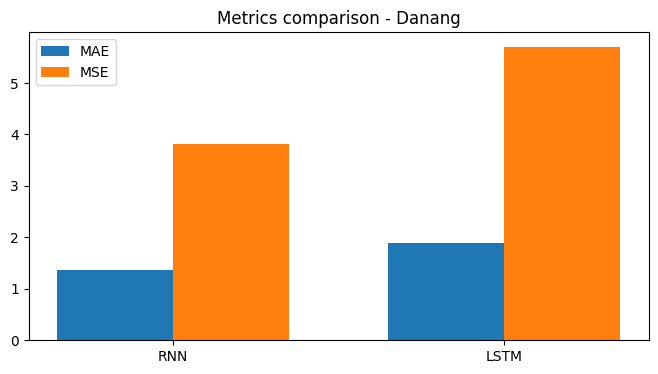

HCMC features: ['day.maxtemp_c', 'day.maxtemp_f', 'day.mintemp_c', 'day.mintemp_f']


C:\Users\nvqua\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step
Metrics for HCMC:
{'RNN': {'MAE': 1.6373853070250994, 'MSE': 4.767727863119957, 'RMSE': 2.1835127348197347, 'R2': 0.26111652667089735}, 'LSTM': {'MAE': 1.7233009677822297, 'MSE': 5.380131384058844, 'RMSE': 2.3195110226206825, 'R2': 0.16620866833223202}}


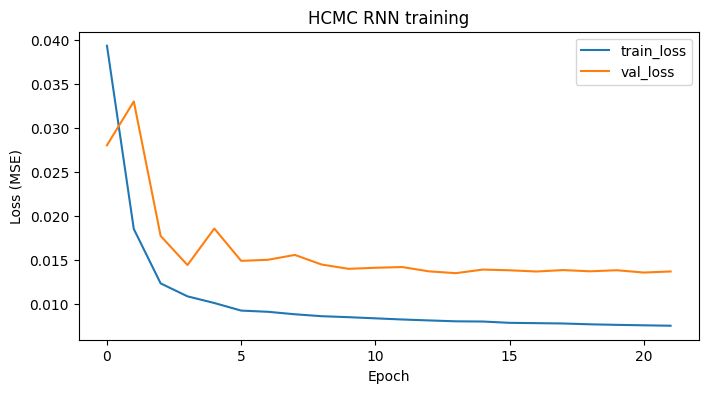

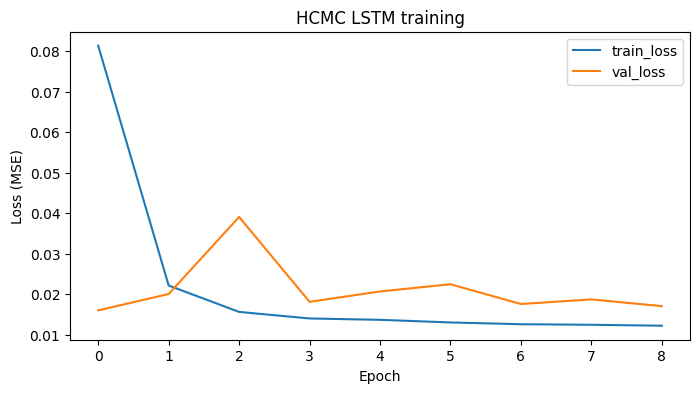

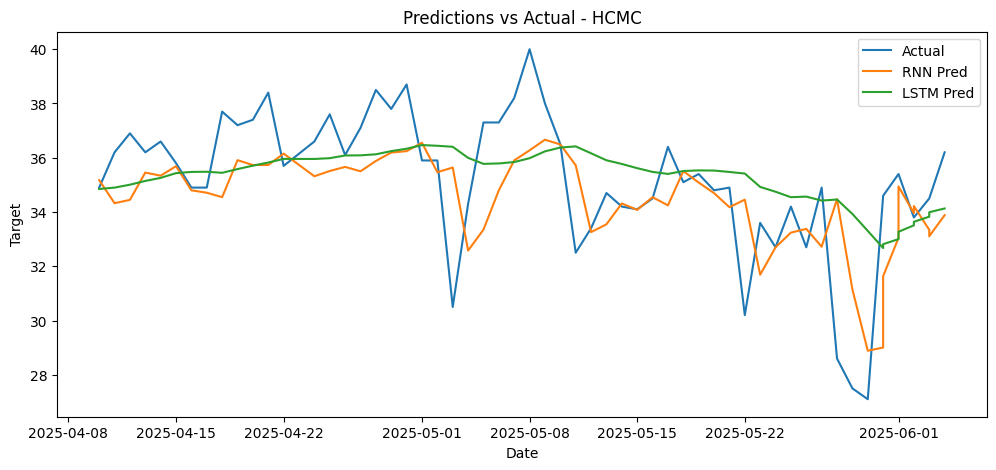

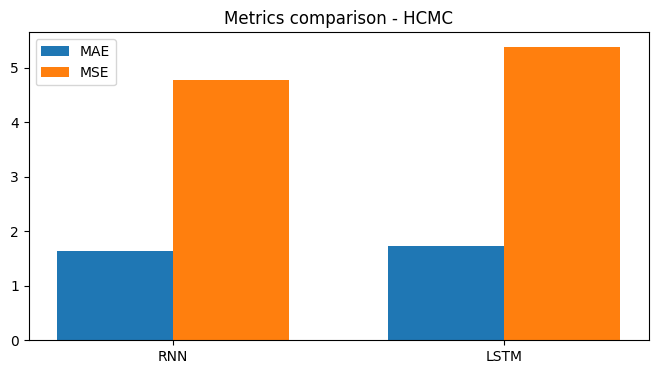


=== Summary comparison across cities ===
     city   rnn_MAE    rnn_MSE  rnn_RMSE    rnn_R2  lstm_MAE   lstm_MSE  \
0   Hanoi  2.576708  10.189694  3.192130  0.319954  2.752221  11.182637   
1  Danang  1.367070   3.820015  1.954486  0.296502  1.892202   5.700257   
2    HCMC  1.637385   4.767728  2.183513  0.261117  1.723301   5.380131   

   lstm_RMSE   lstm_R2  
0   3.344045  0.253686  
1   2.387521 -0.049765  
2   2.319511  0.166209  
Saved models for Hanoi -> model_Hanoi_rnn.h5, model_Hanoi_lstm.h5


Saved models for Danang -> model_Danang_rnn.h5, model_Danang_lstm.h5
Saved models for HCMC -> model_HCMC_rnn.h5, model_HCMC_lstm.h5


In [5]:
# Weather forecasting with RNN and LSTM
# Dataset: user-provided file "weather_2.csv" (from Kaggle link)
# This script follows the 3 phases of deep learning model development (Chapter 5 style):
# 1) Data preparation & exploration
# 2) Modeling (build/train/tune)
# 3) Evaluation & deployment-ready artifacts

# Instructions: Place 'weather_2.csv' in the same folder as this script or update the PATH variable below.
# Run with Python 3.9+; recommended to run inside a virtualenv with packages: numpy,pandas,scikit-learn,matplotlib,tensorflow

"""
Phases (short description to include in any report):

Phase 1 - Data & Problem Framing
  - Understand the problem (forecast daily weather for 3 cities: Ha Noi, Da Nang, HCMC)
  - Inspect dataset (columns, missing data, date ranges)
  - Choose target(s) (e.g., daily average temperature) and input features
  - Split data into train/validation/test (time-based split)

Phase 2 - Modeling
  - Choose candidate models (RNN, LSTM)
  - Prepare time-series windows and normalization
  - Train models, track metrics and losses
  - Tune hyperparameters (sequence length, units, learning rate)

Phase 3 - Evaluation & Delivery
  - Evaluate on hold-out test set using MAE, MSE, RMSE, R2
  - Visualize predictions vs actuals
  - Compare models across cities and metrics
  - Save models and produce a simple inference function for deployment
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# ---------------------------
# User settings
# ---------------------------
DATA_PATH = 'weather2.csv'  # change if needed
CITIES = ['Hanoi', 'Ha Noi', 'Hà Nội', 'HaNoi', 'HANOI']
DANANG_VARIANTS = ['Da Nang', 'Đà Nẵng', 'Danang', 'DA NANG']
HCM_VARIANTS = ['Ho Chi Minh', 'Hồ Chí Minh', 'HCM', 'TP HCM', 'TPHCM', 'TP. Hồ Chí Minh']
TARGET_COLUMN = 'Temperature'  # default target; the script will try to find a matching column
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---------------------------
# Utility functions
# ---------------------------

def load_and_inspect(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}. Please put your CSV there or update DATA_PATH.")
    df = pd.read_csv(path)
    print('\n-- Dataset head --')
    print(df.head())
    print('\n-- Columns --')
    print(df.columns.tolist())
    print('\n-- Dtypes and missing values --')
    print(df.info())
    print('\n-- Missing values count --')
    print(df.isna().sum())
    return df


def normalize_city_name(s):
    if pd.isna(s):
        return s
    s = str(s).strip()
    lowered = s.lower()
    if any(v.lower() == lowered for v in CITIES):
        return 'Hanoi'
    if any(v.lower() == lowered for v in DANANG_VARIANTS):
        return 'Danang'
    if any(v.lower() == lowered for v in HCM_VARIANTS):
        return 'HCMC'
    return s


def prepare_city_df(df, city_label='Hanoi'):
    df = df.copy()
    # try common column names for date and city
    date_cols = [c for c in df.columns if 'date' in c.lower()]
    city_cols = [c for c in df.columns if 'city' in c.lower() or 'location' in c.lower()]

    if not date_cols:
        raise ValueError('No date-like column found in dataset. Please include a Date column.')
    date_col = date_cols[0]

    if not city_cols:
        # perhaps the city is stored in 'Location' or similar
        raise ValueError('No city/location column found. Please ensure dataset contains a city/location column.')
    city_col = city_cols[0]

    df[date_col] = pd.to_datetime(df[date_col])
    df['city_norm'] = df[city_col].apply(normalize_city_name)
    city_df = df[df['city_norm'] == city_label].sort_values(date_col)
    city_df = city_df.reset_index(drop=True)
    return city_df, date_col


def find_numeric_feature_candidates(df):
    # return numeric columns except potential id/index/date/city
    exclude = [c for c in df.columns if 'date' in c.lower() or 'city' in c.lower() or 'location' in c.lower()]
    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    candidates = [c for c in nums if c not in exclude]
    return candidates


def create_sequences(values, seq_len):
    # values: numpy array shape (n_samples, n_features)
    X, y = [], []
    for i in range(len(values) - seq_len):
        X.append(values[i:i+seq_len])
        y.append(values[i+seq_len, 0])  # target is first column in values
    return np.array(X), np.array(y)


def build_rnn_model(input_shape, units=32, lr=0.001):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=input_shape))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model


def build_lstm_model(input_shape, units=50, lr=0.001):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model

# ---------------------------
# Main pipeline function per city
# ---------------------------

def run_pipeline_for_city(df_city, date_col, features, target_col, seq_len=14, test_ratio=0.15, val_ratio=0.15,
                         rnn_params=None, lstm_params=None, epochs=100, batch_size=32):
    """
    df_city: DataFrame for single city sorted by date
    features: list of column names (first in list must be the target column)
    target_col: name of target column (should be features[0])
    """
    if rnn_params is None:
        rnn_params = {}
    if lstm_params is None:
        lstm_params = {}

    data = df_city[features].copy()
    data = data.dropna()
    dates = df_city[date_col].iloc[len(df_city) - len(data):].reset_index(drop=True)

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data.values)

    X, y = create_sequences(scaled, seq_len)
    n_samples = len(X)
    test_size = int(n_samples * test_ratio)
    val_size = int(n_samples * val_ratio)
    train_end = n_samples - test_size - val_size

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:train_end+val_size], y[train_end:train_end+val_size]
    X_test, y_test = X[train_end+val_size:], y[train_end+val_size:]

    # Build and train RNN
    input_shape = (X_train.shape[1], X_train.shape[2])
    rnn_model = build_rnn_model(input_shape, **rnn_params)
    es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    history_rnn = rnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs,
                                batch_size=batch_size, callbacks=[es], verbose=0)

    # Build and train LSTM
    lstm_model = build_lstm_model(input_shape, **lstm_params)
    es2 = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    history_lstm = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs,
                                  batch_size=batch_size, callbacks=[es2], verbose=0)

    # Predictions (remember outputs are scaled for target index 0)
    def inv_transform_target(scaled_y):
        # scaled_y: shape (n,) predicted values corresponding to first feature (target)
        # To invert, we need to create placeholder for other features (use zeros mean)
        dummy = np.zeros((len(scaled_y), scaled.shape[1]))
        dummy[:,0] = scaled_y
        inv = scaler.inverse_transform(dummy)[:,0]
        return inv

    pred_rnn_scaled = rnn_model.predict(X_test).flatten()
    pred_lstm_scaled = lstm_model.predict(X_test).flatten()
    y_test_inv = inv_transform_target(y_test)
    pred_rnn_inv = inv_transform_target(pred_rnn_scaled)
    pred_lstm_inv = inv_transform_target(pred_lstm_scaled)

    # Metrics
    metrics = {}
    for name, y_pred in [('RNN', pred_rnn_inv), ('LSTM', pred_lstm_inv)]:
        mae = mean_absolute_error(y_test_inv, y_pred)
        mse = mean_squared_error(y_test_inv, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_inv, y_pred)
        metrics[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

    results = {
        'scaler': scaler,
        'rnn_model': rnn_model,
        'lstm_model': lstm_model,
        'history_rnn': history_rnn.history,
        'history_lstm': history_lstm.history,
        'X_test_dates': dates.iloc[seq_len + train_end + val_size:].reset_index(drop=True) if len(dates) > 0 else None,
        'y_test': y_test_inv,
        'pred_rnn': pred_rnn_inv,
        'pred_lstm': pred_lstm_inv,
        'metrics': metrics
    }
    return results

# ---------------------------
# Plotting utilities
# ---------------------------

def plot_training_history(history, title='Training loss'):
    plt.figure(figsize=(8,4))
    plt.plot(history['loss'], label='train_loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()


def plot_predictions(dates, actual, pred1, pred2, city_name='City'):
    plt.figure(figsize=(12,5))
    plt.plot(dates, actual, label='Actual')
    plt.plot(dates, pred1, label='RNN Pred')
    plt.plot(dates, pred2, label='LSTM Pred')
    plt.title(f'Predictions vs Actual - {city_name}')
    plt.xlabel('Date')
    plt.ylabel('Target')
    plt.legend()
    plt.show()


def plot_comparison_bar(metrics_dict, city_name='City'):
    # metrics_dict: {'RNN': {'MAE':..,'MSE':..}, 'LSTM': {...}}
    names = list(metrics_dict.keys())
    maes = [metrics_dict[n]['MAE'] for n in names]
    mses = [metrics_dict[n]['MSE'] for n in names]

    x = np.arange(len(names))
    width = 0.35

    plt.figure(figsize=(8,4))
    plt.bar(x - width/2, maes, width, label='MAE')
    plt.bar(x + width/2, mses, width, label='MSE')
    plt.xticks(x, names)
    plt.title(f'Metrics comparison - {city_name}')
    plt.legend()
    plt.show()

# ---------------------------
# Run for each city (main)
# ---------------------------

def main(path=DATA_PATH):
    df = load_and_inspect(path)

    # Try to find target column intelligently
    possible_temp_cols = [c for c in df.columns if 'temp' in c.lower()]
    global TARGET_COLUMN
    if possible_temp_cols:
        TARGET_COLUMN = possible_temp_cols[0]
        print(f"Using target column: {TARGET_COLUMN}")
    else:
        print('No obvious temperature column found. Using default TARGET_COLUMN value; you may need to adjust it.')

    # We'll attempt to extract city-specific dataframes for three target cities
    cities = {'Hanoi': None, 'Danang': None, 'HCMC': None}
    for city_label in cities.keys():
        try:
            df_city, date_col = prepare_city_df(df, city_label)
            if df_city.empty:
                print(f'No rows for {city_label}')
            else:
                cities[city_label] = (df_city, date_col)
                print(f'Prepared {len(df_city)} rows for {city_label}')
        except Exception as e:
            print(f'Could not prepare dataframe for {city_label}: {e}')

    # For each city, choose features automatically: pick target + up to 3 numeric features
    overall_results = {}
    for city_name, item in cities.items():
        if item is None:
            continue
        df_city, date_col = item
        candidates = find_numeric_feature_candidates(df_city)
        if TARGET_COLUMN not in candidates:
            # Maybe the target isn't numeric or has different name; try to pick first numeric
            if candidates:
                target = candidates[0]
            else:
                print(f'No numeric candidates for {city_name}, skipping...')
                continue
        else:
            target = TARGET_COLUMN
        # assemble features: target first, then up to 3 more features
        other_feats = [c for c in candidates if c != target][:3]
        features = [target] + other_feats
        print(f'{city_name} features: {features}')

        results = run_pipeline_for_city(df_city, date_col, features, target_col=target,
                                        seq_len=14, epochs=100, batch_size=32)

        overall_results[city_name] = {'features': features, 'results': results}

        # plots
        print(f"Metrics for {city_name}:")
        print(results['metrics'])
        plot_training_history(results['history_rnn'], title=f'{city_name} RNN training')
        plot_training_history(results['history_lstm'], title=f'{city_name} LSTM training')
        # plot predictions if dates available
        if results['X_test_dates'] is not None and len(results['y_test'])>0:
            plot_predictions(results['X_test_dates'], results['y_test'], results['pred_rnn'], results['pred_lstm'], city_name)
            plot_comparison_bar(results['metrics'], city_name)

    # Summary table
    rows = []
    for city, v in overall_results.items():
        metrics = v['results']['metrics']
        row = {
            'city': city,
            'rnn_MAE': metrics['RNN']['MAE'],
            'rnn_MSE': metrics['RNN']['MSE'],
            'rnn_RMSE': metrics['RNN']['RMSE'],
            'rnn_R2': metrics['RNN']['R2'],
            'lstm_MAE': metrics['LSTM']['MAE'],
            'lstm_MSE': metrics['LSTM']['MSE'],
            'lstm_RMSE': metrics['LSTM']['RMSE'],
            'lstm_R2': metrics['LSTM']['R2']
        }
        rows.append(row)
    if rows:
        summary_df = pd.DataFrame(rows)
        print('\n=== Summary comparison across cities ===')
        print(summary_df)

    # Optionally save models
    SAVE_MODELS = True
    if SAVE_MODELS:
        for city, v in overall_results.items():
            res = v['results']
            rnn_path = f'model_{city}_rnn.h5'
            lstm_path = f'model_{city}_lstm.h5'
            res['rnn_model'].save(rnn_path)
            res['lstm_model'].save(lstm_path)
            print(f'Saved models for {city} -> {rnn_path}, {lstm_path}')

    return overall_results


if __name__ == '__main__':
    main()


In [ ]:
# Weather forecasting with RNN and LSTM (with detailed comments)
# Dataset: user-provided file "weather_2.csv"
# This script is divided into 3 phases according to Deep Learning development process (Chapter 5):
# Phase 1 - Data Preparation & Exploration
# Phase 2 - Modeling (Build, Train, Tune)
# Phase 3 - Evaluation & Comparison

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# ---------------------------
# Configuration
# ---------------------------
DATA_PATH = 'weather2.csv'  # path to dataset
CITIES = ['Hanoi', 'Ha Noi', 'Hà Nội']
DANANG_VARIANTS = ['Da Nang', 'Đà Nẵng']
HCM_VARIANTS = ['Ho Chi Minh', 'Hồ Chí Minh', 'TPHCM']
TARGET_COLUMN = 'Temperature'
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ==================================================
# PHASE 1: DATA PREPARATION & EXPLORATION
# Nguyễn Việt Quang B22DCCN650
# ==================================================

def load_and_inspect(path):
    """Load dataset and print structure for exploration"""
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    df = pd.read_csv(path)
    print("\n-- Dataset Info --")
    print(df.info())
    print("\n-- Missing values --")
    print(df.isna().sum())
    print("\n-- Head --")
    print(df.head())
    return df

def normalize_city_name(s):
    s = str(s).strip().lower()
    if s in [c.lower() for c in CITIES]:
        return 'Hanoi'
    if s in [c.lower() for c in DANANG_VARIANTS]:
        return 'Danang'
    if s in [c.lower() for c in HCM_VARIANTS]:
        return 'HCMC'
    return s

# Nguyễn Việt Quang B22DCCN650
def prepare_city_df(df, city_label='Hanoi'):
    """Filter dataset by city and convert date"""
    date_col = [c for c in df.columns if 'date' in c.lower()][0]
    city_col = [c for c in df.columns if 'city' in c.lower() or 'location' in c.lower()][0]
    df[date_col] = pd.to_datetime(df[date_col])
    df['city_norm'] = df[city_col].apply(normalize_city_name)
    city_df = df[df['city_norm'] == city_label].sort_values(date_col)
    return city_df.reset_index(drop=True), date_col

def find_numeric_feature_candidates(df):
    exclude = [c for c in df.columns if 'date' in c.lower() or 'city' in c.lower()]
    return [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude]

# ==================================================
# PHASE 2: MODELING (RNN & LSTM)
# Nguyễn Việt Quang B22DCCN650
# ==================================================

def create_sequences(values, seq_len):
    """Convert time-series data into sequences for RNN/LSTM"""
    X, y = [], []
    for i in range(len(values) - seq_len):
        X.append(values[i:i+seq_len])
        y.append(values[i+seq_len, 0])  # predict target of next day
    return np.array(X), np.array(y)

def build_rnn_model(input_shape, units=32, lr=0.001):
    """Simple RNN model"""
    model = Sequential([
        SimpleRNN(units, input_shape=input_shape),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model

# Nguyễn Việt Quang B22DCCN650
def build_lstm_model(input_shape, units=50, lr=0.001):
    """LSTM model"""
    model = Sequential([
        LSTM(units, input_shape=input_shape),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model

def run_pipeline_for_city(df_city, date_col, features, target_col, seq_len=14, test_ratio=0.15, val_ratio=0.15):
    """Train & evaluate RNN and LSTM for one city"""
    data = df_city[features].dropna()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)

    X, y = create_sequences(scaled, seq_len)
    n = len(X)
    test_size, val_size = int(n*test_ratio), int(n*val_ratio)
    X_train, X_val, X_test = X[:-val_size-test_size], X[-val_size-test_size:-test_size], X[-test_size:]
    y_train, y_val, y_test = y[:-val_size-test_size], y[-val_size-test_size:-test_size], y[-test_size:]

    # --- RNN Training ---
    rnn = build_rnn_model((X_train.shape[1], X_train.shape[2]))
    es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    hist_rnn = rnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[es])

# Nguyễn Việt Quang B22DCCN650
    # --- LSTM Training ---
    lstm = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    hist_lstm = lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0, callbacks=[es])

    # --- Prediction ---
    def inv_transform(pred):
        dummy = np.zeros((len(pred), scaled.shape[1]))
        dummy[:,0] = pred
        return scaler.inverse_transform(dummy)[:,0]

    pred_rnn = inv_transform(rnn.predict(X_test).flatten())
    pred_lstm = inv_transform(lstm.predict(X_test).flatten())
    y_true = inv_transform(y_test)

    # --- Metrics ---
    metrics = {}
    for name, pred in [('RNN', pred_rnn), ('LSTM', pred_lstm)]:
        mae = mean_absolute_error(y_true, pred)
        mse = mean_squared_error(y_true, pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, pred)
        metrics[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

    return hist_rnn, hist_lstm, y_true, pred_rnn, pred_lstm, metrics

# ==================================================
# PHASE 3: EVALUATION & VISUALIZATION
# Nguyễn Việt Quang B22DCCN650
# ==================================================

def plot_training(history, title):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

def plot_predictions(y_true, pred_rnn, pred_lstm, city):
    plt.figure(figsize=(10,5))
    plt.plot(y_true, label='Actual')
    plt.plot(pred_rnn, label='RNN')
    plt.plot(pred_lstm, label='LSTM')
    plt.title(f'Predictions vs Actual ({city})')
    plt.legend()
    plt.show()

    # Nguyễn Việt Quang B22DCCN650
def plot_comparison(metrics, city):
    models = list(metrics.keys())
    maes = [metrics[m]['MAE'] for m in models]
    mses = [metrics[m]['MSE'] for m in models]
    plt.bar(models, maes, label='MAE')
    plt.bar(models, mses, alpha=0.7, label='MSE')
    plt.title(f'Model Comparison ({city})')
    plt.legend()
    plt.show()

# ==================================================
# MAIN PIPELINE
# ==================================================

def main():
    df = load_and_inspect(DATA_PATH)
    cities = {'Hanoi': None, 'Danang': None, 'HCMC': None}

    # --- Prepare data for each city ---
    for city in cities.keys():
        try:
            df_city, date_col = prepare_city_df(df, city)
            if df_city.empty:
                continue
            features = [TARGET_COLUMN] + find_numeric_feature_candidates(df_city)[:3]
            print(f'City: {city}, features: {features}')

            hist_rnn, hist_lstm, y_true, pred_rnn, pred_lstm, metrics = run_pipeline_for_city(df_city, date_col, features, TARGET_COLUMN)

            print(f'Metrics for {city}:', metrics)

            # --- Plotting ---
            plot_training(hist_rnn, f'{city} RNN Training')
            plot_training(hist_lstm, f'{city} LSTM Training')
            plot_predictions(y_true, pred_rnn, pred_lstm, city)
            plot_comparison(metrics, city)
        except Exception as e:
            print(f'Skipping {city}: {e}')

if __name__ == '__main__':
    main()